# **EfficientNet**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import torch
import torchsummary
import torch.nn as nn
import torch.optim as optim

In [2]:
import os
import sys

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
BASE_DIR = os.path.basename(project_root)

In [15]:
from src.dataloader import get_data_loaders
from src.model import EfficientNetDF
from src.train import train_one_epoch, evaluate
from src.utils import set_seed, save_checkpoint, save_experiment_json, performance, get_device, error_analysis, plot_error_analysis

In [8]:
DATA_ROOT = '../data/'
RESULTS_DIR = '../results/efficient-net'
MODEL_WEIGHTS = '../model_checkpoints/efficient-net'
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODEL_WEIGHTS, exist_ok=True)

In [5]:
torch.backends.cudnn.benchmark = True
DEVICE = torch.device(get_device())
set_seed(42)

In [6]:
print(f"Base directory: {BASE_DIR}")
print(f"Device: {DEVICE}")

Base directory: deep_fake_detection
Device: mps


## **Without Augmentation & Label Smoothing**

In [10]:
MODEL_NAME = 'efficientnet'
TASK_NAME = 'no_aug'
BATCH_SIZE = 32

EPOCHS_STAGE_1 = 10
LR_STAGE_1 = 1e-3

EPOCHS_STAGE_2 =20
LR_STAGE_2 = 1e-5

In [9]:
train_loader, valid_loader, test_loader = get_data_loaders(
    DATA_ROOT, MODEL_NAME, BATCH_SIZE, use_augmentation=False)

In [10]:
model = EfficientNetDF(num_classes=2,  pretrained=True).to(DEVICE)
torchsummary.summary(model, (3, 224, 224), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 32, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             264
              SiLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 32, 1, 1]             288
          Sigmoid-11             [32, 32, 1, 1]               0
SqueezeExcitation-12         [32, 32, 112, 112]               0
           Conv2d-13         [32, 16, 112, 112]             512
      BatchNorm2d-14         [32, 16, 1

### **Pre-train**

In [11]:
# Freeze Backbone for Initial Training
for param in model.model.features.parameters():
    param.requires_grad = False

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable Parameters (Stage 1):", trainable_params)

Trainable Parameters (Stage 1): 2562


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR_STAGE_1)

In [13]:
history = {
    'model_name': MODEL_NAME,
    'EPOCHS': EPOCHS_STAGE_1 + EPOCHS_STAGE_2,
    'model_saved_path': '',
    'train_losses': [],
    'valid_losses': [],
    'train_accuracy': [],
    'valid_accuracy': [],
    'valid_f1': [],
    'valid_auc': [],
    'best_accuracy': [],
    'best_epoch': [],
}

In [14]:
best_acc = 0.0

for epoch in range(EPOCHS_STAGE_1):
    # Train & Evaluate
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    print(f"[{epoch + 1}/{EPOCHS_STAGE_1}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    # Metrics record
    history['train_losses'].append(train_loss)
    history['valid_losses'].append(valid_loss)
    history['train_accuracy'].append(train_acc)
    history['valid_accuracy'].append(valid_acc)
    history['valid_f1'].append(valid_f1)
    history['valid_auc'].append(valid_auc)
    
    # Save best model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"{MODEL_WEIGHTS}/best_{MODEL_NAME}_{TASK_NAME}_pretrained.pth"
        save_checkpoint(model, optimizer, save_name)
        
        # Update best stats
        history['best_accuracy'] = best_acc
        history['best_epoch'] = epoch + 1
        history['model_saved_path'] = save_name
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 94/94 [00:11<00:00,  7.94it/s]


[1/10] train_acc: 0.6280 - train_loss: 0.6406 - valid_acc: 0.6289 - valid_loss: 0.6493
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_no_aug_pretrained.pth
	- [current best] epoch: 1 - acc: 0.6289



Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.53it/s]


[2/10] train_acc: 0.6468 - train_loss: 0.6284 - valid_acc: 0.6594 - valid_loss: 0.6168
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_no_aug_pretrained.pth
	- [current best] epoch: 2 - acc: 0.6594



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.00it/s]


[3/10] train_acc: 0.6551 - train_loss: 0.6183 - valid_acc: 0.6597 - valid_loss: 0.6207
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_no_aug_pretrained.pth
	- [current best] epoch: 3 - acc: 0.6597



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.08it/s]


[4/10] train_acc: 0.6608 - train_loss: 0.6204 - valid_acc: 0.6500 - valid_loss: 0.6218
	- [current best] epoch: 3 - acc: 0.6597



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.08it/s]


[5/10] train_acc: 0.6548 - train_loss: 0.6230 - valid_acc: 0.6483 - valid_loss: 0.6266
	- [current best] epoch: 3 - acc: 0.6597



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.09it/s]


[6/10] train_acc: 0.6597 - train_loss: 0.6167 - valid_acc: 0.6570 - valid_loss: 0.6175
	- [current best] epoch: 3 - acc: 0.6597



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.06it/s]


[7/10] train_acc: 0.6555 - train_loss: 0.6198 - valid_acc: 0.6483 - valid_loss: 0.6252
	- [current best] epoch: 3 - acc: 0.6597



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.09it/s]


[8/10] train_acc: 0.6538 - train_loss: 0.6244 - valid_acc: 0.6416 - valid_loss: 0.6306
	- [current best] epoch: 3 - acc: 0.6597



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.02it/s]


[9/10] train_acc: 0.6557 - train_loss: 0.6214 - valid_acc: 0.6477 - valid_loss: 0.6263
	- [current best] epoch: 3 - acc: 0.6597



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.11it/s]

[10/10] train_acc: 0.6622 - train_loss: 0.6180 - valid_acc: 0.6436 - valid_loss: 0.6311
	- [current best] epoch: 3 - acc: 0.6597



In [15]:
save_name = f"{MODEL_WEIGHTS}/{MODEL_NAME}_{TASK_NAME}_pretrained.pth"
save_checkpoint(model, optimizer, save_name)

Checkpoint saved: ../model_checkpoints/efficient-net/efficientnet_no_aug_pretrained.pth


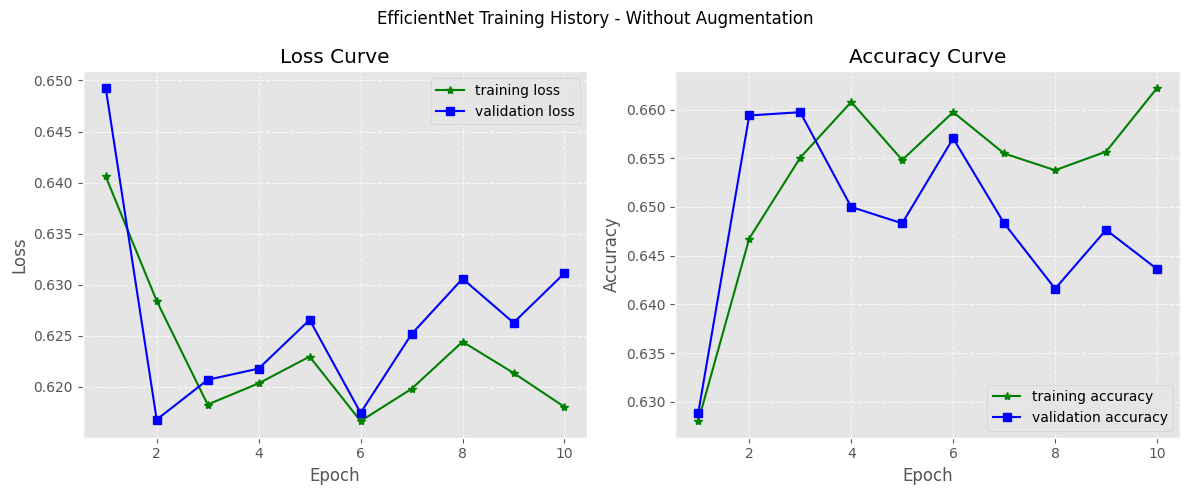

In [16]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

epochs = range(1, len(history["train_losses"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("EfficientNet Training History - Without Augmentation")

ax[0].plot(epochs, history["train_losses"], label='training loss', marker='*', color='green')
ax[0].plot(epochs, history["valid_losses"], label='validation loss', marker='s', color='blue')
ax[0].set_title("Loss Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.7)

ax[1].plot(epochs, history["train_accuracy"], label='training accuracy', marker='*', color='green')
ax[1].plot(epochs, history["valid_accuracy"], label='validation accuracy', marker='s', color='blue')
ax[1].set_title("Accuracy Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.7)

img_save = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}_pretrained.png"
plt.savefig(img_save)
plt.tight_layout()
plt.show()

### **Fine-Tuning**

In [17]:
# Unfreeze for Fine-Tuning
for param in model.parameters():
    param.requires_grad = True

In [18]:
optimizer = optim.Adam(model.parameters(), lr=LR_STAGE_2)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters (Stage 2): {trainable_params}")

Trainable Parameters (Stage 2): 4010110


In [19]:
TOTAL_EPOCHS = EPOCHS_STAGE_1 + EPOCHS_STAGE_2
for epoch in range(EPOCHS_STAGE_1, TOTAL_EPOCHS):
    # Train & Evaluate
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    print(f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    # Metrics record
    history['train_losses'].append(train_loss)
    history['valid_losses'].append(valid_loss)
    history['train_accuracy'].append(train_acc)
    history['valid_accuracy'].append(valid_acc)
    history['valid_f1'].append(valid_f1)
    history['valid_auc'].append(valid_auc)
    
    # Save best model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"{MODEL_WEIGHTS}/best_{MODEL_NAME}_{TASK_NAME}_finetuned.pth"
        save_checkpoint(model, optimizer, save_name)
        
        # Update best stats
        history['best_accuracy'] = best_acc
        history['best_epoch'] = epoch + 1
        history['model_saved_path'] = save_name
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.26it/s]


[11/30 (Fine-Tune)] train_acc: 0.7102 - train_loss: 0.5580 - valid_acc: 0.7326 - valid_loss: 0.5287
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_no_aug_finetuned.pth
	- [current best] epoch: 11 - acc: 0.7326



Evaluating: 100%|██████████| 94/94 [00:14<00:00,  6.42it/s]


[12/30 (Fine-Tune)] train_acc: 0.7760 - train_loss: 0.4644 - valid_acc: 0.7836 - valid_loss: 0.4671
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_no_aug_finetuned.pth
	- [current best] epoch: 12 - acc: 0.7836



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.17it/s]


[13/30 (Fine-Tune)] train_acc: 0.8299 - train_loss: 0.3807 - valid_acc: 0.8081 - valid_loss: 0.4310
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_no_aug_finetuned.pth
	- [current best] epoch: 13 - acc: 0.8081



Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.28it/s]


[14/30 (Fine-Tune)] train_acc: 0.8591 - train_loss: 0.3233 - valid_acc: 0.8161 - valid_loss: 0.4112
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_no_aug_finetuned.pth
	- [current best] epoch: 14 - acc: 0.8161



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.23it/s]


[15/30 (Fine-Tune)] train_acc: 0.8835 - train_loss: 0.2763 - valid_acc: 0.8285 - valid_loss: 0.3949
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_no_aug_finetuned.pth
	- [current best] epoch: 15 - acc: 0.8285



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.18it/s]


[16/30 (Fine-Tune)] train_acc: 0.9006 - train_loss: 0.2435 - valid_acc: 0.8416 - valid_loss: 0.3883
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_no_aug_finetuned.pth
	- [current best] epoch: 16 - acc: 0.8416



Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.30it/s]


[17/30 (Fine-Tune)] train_acc: 0.9126 - train_loss: 0.2154 - valid_acc: 0.8460 - valid_loss: 0.3864
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_no_aug_finetuned.pth
	- [current best] epoch: 17 - acc: 0.8460



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.12it/s]


[18/30 (Fine-Tune)] train_acc: 0.9226 - train_loss: 0.1933 - valid_acc: 0.8577 - valid_loss: 0.3762
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_no_aug_finetuned.pth
	- [current best] epoch: 18 - acc: 0.8577



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.20it/s]


[19/30 (Fine-Tune)] train_acc: 0.9320 - train_loss: 0.1698 - valid_acc: 0.8628 - valid_loss: 0.3681
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_no_aug_finetuned.pth
	- [current best] epoch: 19 - acc: 0.8628



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.15it/s]


[20/30 (Fine-Tune)] train_acc: 0.9404 - train_loss: 0.1517 - valid_acc: 0.8651 - valid_loss: 0.3724
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_no_aug_finetuned.pth
	- [current best] epoch: 20 - acc: 0.8651



Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.32it/s]


[21/30 (Fine-Tune)] train_acc: 0.9430 - train_loss: 0.1451 - valid_acc: 0.8540 - valid_loss: 0.4010
	- [current best] epoch: 20 - acc: 0.8651



Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.24it/s]


[22/30 (Fine-Tune)] train_acc: 0.9498 - train_loss: 0.1304 - valid_acc: 0.8691 - valid_loss: 0.3807
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_no_aug_finetuned.pth
	- [current best] epoch: 22 - acc: 0.8691



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.23it/s]


[23/30 (Fine-Tune)] train_acc: 0.9564 - train_loss: 0.1131 - valid_acc: 0.8661 - valid_loss: 0.3977
	- [current best] epoch: 22 - acc: 0.8691



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.16it/s]


[24/30 (Fine-Tune)] train_acc: 0.9556 - train_loss: 0.1116 - valid_acc: 0.8607 - valid_loss: 0.4159
	- [current best] epoch: 22 - acc: 0.8691



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.04it/s]


[25/30 (Fine-Tune)] train_acc: 0.9622 - train_loss: 0.0992 - valid_acc: 0.8755 - valid_loss: 0.3871
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_no_aug_finetuned.pth
	- [current best] epoch: 25 - acc: 0.8755



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.11it/s]


[26/30 (Fine-Tune)] train_acc: 0.9648 - train_loss: 0.0952 - valid_acc: 0.8671 - valid_loss: 0.4142
	- [current best] epoch: 25 - acc: 0.8755



Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.26it/s]


[27/30 (Fine-Tune)] train_acc: 0.9666 - train_loss: 0.0883 - valid_acc: 0.8604 - valid_loss: 0.4571
	- [current best] epoch: 25 - acc: 0.8755



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.18it/s]


[28/30 (Fine-Tune)] train_acc: 0.9673 - train_loss: 0.0824 - valid_acc: 0.8671 - valid_loss: 0.4372
	- [current best] epoch: 25 - acc: 0.8755



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.17it/s]


[29/30 (Fine-Tune)] train_acc: 0.9709 - train_loss: 0.0776 - valid_acc: 0.8755 - valid_loss: 0.4116
	- [current best] epoch: 25 - acc: 0.8755



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.10it/s]

[30/30 (Fine-Tune)] train_acc: 0.9718 - train_loss: 0.0745 - valid_acc: 0.8728 - valid_loss: 0.4295
	- [current best] epoch: 25 - acc: 0.8755



In [20]:
save_name = f"{MODEL_WEIGHTS}/{MODEL_NAME}_{TASK_NAME}_finetuned.pth"
save_checkpoint(model, optimizer, save_name)

Checkpoint saved: ../model_checkpoints/efficient-net/efficientnet_no_aug_finetuned.pth


In [21]:
json_filename = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}.json"
save_experiment_json(history, json_filename)

History saved to ../results/efficient-net/efficientnet_no_aug.json


<Figure size 1200x600 with 0 Axes>

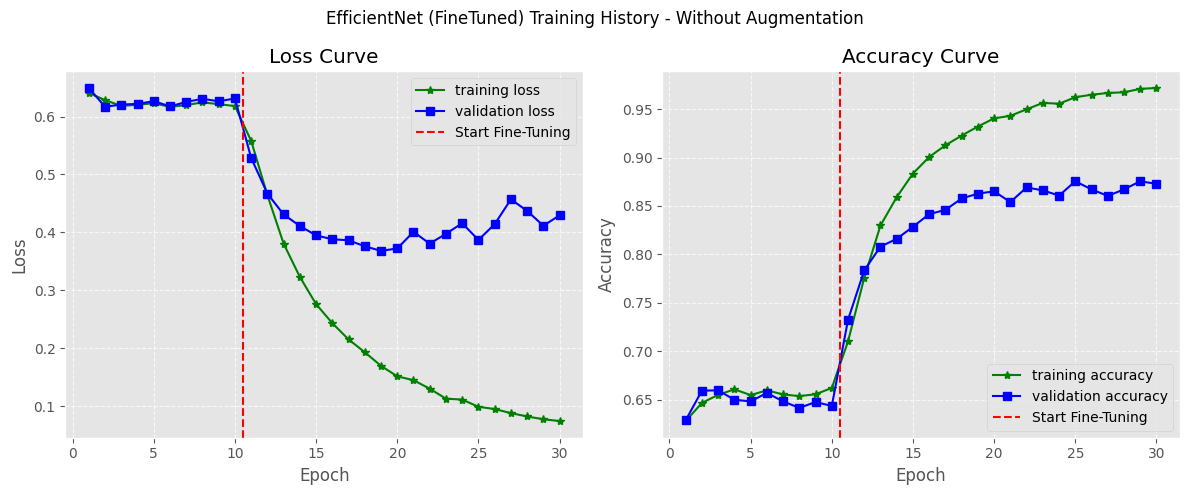

In [22]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))

epochs = range(1, len(history["train_losses"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("EfficientNet (FineTuned) Training History - Without Augmentation")

ax[0].plot(epochs, history["train_losses"], label='training loss', marker='*', color='green')
ax[0].plot(epochs, history["valid_losses"], label='validation loss', marker='s', color='blue')
ax[0].set_title("Loss Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].axvline(x=EPOCHS_STAGE_1 + 0.5, color='red', linestyle='--', label='Start Fine-Tuning')
ax[0].legend()

ax[1].plot(epochs, history["train_accuracy"], label='training accuracy', marker='*', color='green')
ax[1].plot(epochs, history["valid_accuracy"], label='validation accuracy', marker='s', color='blue')
ax[1].set_title("Accuracy Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].axvline(x=EPOCHS_STAGE_1 + 0.5, color='red', linestyle='--', label='Start Fine-Tuning')
ax[1].legend()

img_save = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}.png"
plt.savefig(img_save)
plt.tight_layout()
plt.show()

In [13]:
save_name = f"{MODEL_WEIGHTS}/{MODEL_NAME}_{TASK_NAME}_finetuned.pth"
checkpoint = torch.load(save_name, map_location=DEVICE)
model.load_state_dict(checkpoint["state_dict"])
model = model.to(device=DEVICE)

Deepfakes : 0.9536
Face2Face : 0.9172
FaceSwap : 0.8907
FaceShifter : 0.9338
NeuralTextures : 0.8874


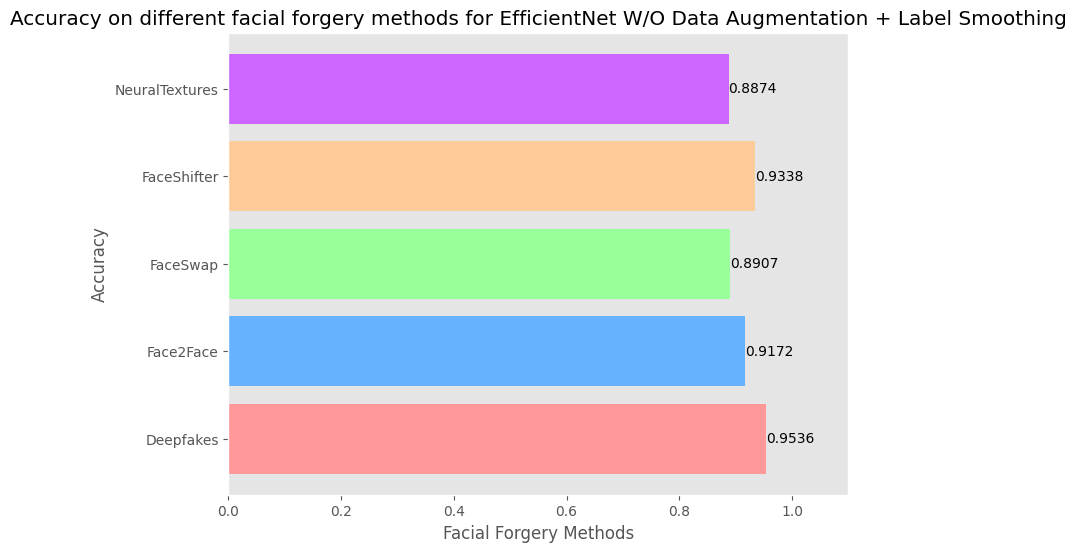

In [16]:
summary = error_analysis(model = model, fake_image_path = f"{project_root}/data/test/fake", model_name = MODEL_NAME, device = DEVICE)
plot_error_analysis(summary, model_name = "EfficientNet W/O Data Augmentation + Label Smoothing")



Getting predictions: 100%|██████████| 95/95 [00:13<00:00,  7.12it/s]


Accuracy score: 0.8805
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.84      0.88      1510
           1       0.85      0.92      0.88      1510

    accuracy                           0.88      3020
   macro avg       0.88      0.88      0.88      3020
weighted avg       0.88      0.88      0.88      3020



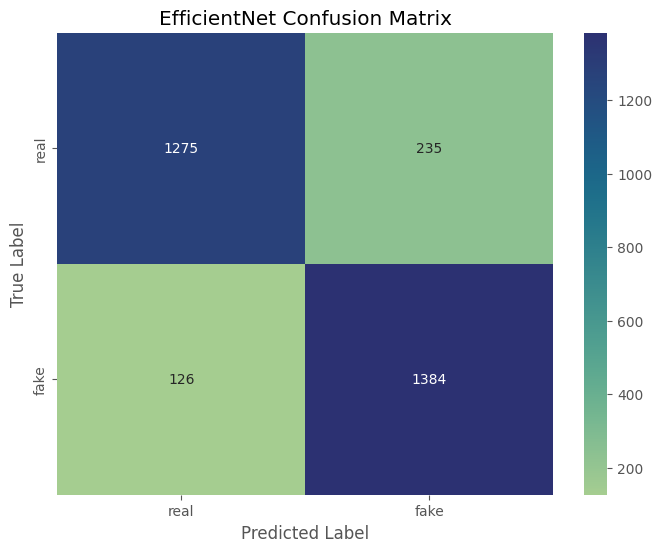

In [23]:
performance(model, test_loader, DEVICE, "EfficientNet", TASK_NAME, RESULTS_DIR)

## **With Augmentaion**

In [19]:
MODEL_NAME = 'efficientnet'
TASK_NAME = 'with_aug'
BATCH_SIZE = 32

EPOCHS_STAGE_1 = 10
LR_STAGE_1 = 1e-3

EPOCHS_STAGE_2 =20
LR_STAGE_2 = 1e-5

In [25]:
LABEL_SMOOTHING = 0.1
WEIGHT_DECAY = 1e-2

In [26]:
train_loader, valid_loader, test_loader = get_data_loaders(
    DATA_ROOT, MODEL_NAME, BATCH_SIZE, use_augmentation=True)

In [27]:
model = EfficientNetDF(num_classes=2,  pretrained=True).to(DEVICE)
torchsummary.summary(model, (3, 224, 224), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 32, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             264
              SiLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 32, 1, 1]             288
          Sigmoid-11             [32, 32, 1, 1]               0
SqueezeExcitation-12         [32, 32, 112, 112]               0
           Conv2d-13         [32, 16, 112, 112]             512
      BatchNorm2d-14         [32, 16, 1

### **Pre-train**

In [28]:
# Freeze Backbone for Initial Training
for param in model.model.features.parameters():
    param.requires_grad = False

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable Parameters (Stage 1):", trainable_params)

Trainable Parameters (Stage 1): 2562


In [29]:
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = optim.Adam(model.parameters(), lr=LR_STAGE_1, weight_decay=WEIGHT_DECAY)

In [30]:
history_aug = {
    'model_name': MODEL_NAME,
    'EPOCHS': EPOCHS_STAGE_1 + EPOCHS_STAGE_2,
    'model_saved_path': '',
    'weight_decay': WEIGHT_DECAY,
    'label_smoothing': LABEL_SMOOTHING,
    'train_losses': [],
    'valid_losses': [],
    'train_accuracy': [],
    'valid_accuracy': [],
    'valid_f1': [],
    'valid_auc': [],
    'best_accuracy': [],
    'best_epoch': [],
}

In [31]:
best_acc = 0.0

for epoch in range(EPOCHS_STAGE_1):
    # Train & Evaluate
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    print(f"[{epoch + 1}/{EPOCHS_STAGE_1}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    # Metrics record
    history_aug['train_losses'].append(train_loss)
    history_aug['valid_losses'].append(valid_loss)
    history_aug['train_accuracy'].append(train_acc)
    history_aug['valid_accuracy'].append(valid_acc)
    history_aug['valid_f1'].append(valid_f1)
    history_aug['valid_auc'].append(valid_auc)
    
    # Save best model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"{MODEL_WEIGHTS}/best_{MODEL_NAME}_{TASK_NAME}_pretrained.pth"
        save_checkpoint(model, optimizer, save_name)
        
        # Update best stats
        history_aug['best_accuracy'] = best_acc
        history_aug['best_epoch'] = epoch + 1
        history_aug['model_saved_path'] = save_name
        
    print(f"\t- [current best] epoch: {history_aug['best_epoch']} - acc: {history_aug['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 94/94 [00:13<00:00,  6.98it/s]


[1/10] train_acc: 0.6174 - train_loss: 0.6582 - valid_acc: 0.6285 - valid_loss: 0.6489
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_pretrained.pth
	- [current best] epoch: 1 - acc: 0.6285



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.06it/s]


[2/10] train_acc: 0.6372 - train_loss: 0.6481 - valid_acc: 0.6416 - valid_loss: 0.6484
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_pretrained.pth
	- [current best] epoch: 2 - acc: 0.6416



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.19it/s]


[3/10] train_acc: 0.6492 - train_loss: 0.6417 - valid_acc: 0.6419 - valid_loss: 0.6439
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_pretrained.pth
	- [current best] epoch: 3 - acc: 0.6419



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.05it/s]


[4/10] train_acc: 0.6442 - train_loss: 0.6436 - valid_acc: 0.6399 - valid_loss: 0.6457
	- [current best] epoch: 3 - acc: 0.6419



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.06it/s]


[5/10] train_acc: 0.6432 - train_loss: 0.6445 - valid_acc: 0.6295 - valid_loss: 0.6617
	- [current best] epoch: 3 - acc: 0.6419



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.11it/s]


[6/10] train_acc: 0.6482 - train_loss: 0.6420 - valid_acc: 0.6406 - valid_loss: 0.6557
	- [current best] epoch: 3 - acc: 0.6419



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.04it/s]


[7/10] train_acc: 0.6446 - train_loss: 0.6450 - valid_acc: 0.6426 - valid_loss: 0.6473
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_pretrained.pth
	- [current best] epoch: 7 - acc: 0.6426



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.01it/s]


[8/10] train_acc: 0.6477 - train_loss: 0.6413 - valid_acc: 0.6399 - valid_loss: 0.6454
	- [current best] epoch: 7 - acc: 0.6426



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  7.95it/s]


[9/10] train_acc: 0.6460 - train_loss: 0.6449 - valid_acc: 0.6346 - valid_loss: 0.6437
	- [current best] epoch: 7 - acc: 0.6426



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.00it/s]

[10/10] train_acc: 0.6460 - train_loss: 0.6455 - valid_acc: 0.6188 - valid_loss: 0.6670
	- [current best] epoch: 7 - acc: 0.6426



In [32]:
save_name = f"{MODEL_WEIGHTS}/{MODEL_NAME}_{TASK_NAME}_pretrained.pth"
save_checkpoint(model, optimizer, save_name)

Checkpoint saved: ../model_checkpoints/efficient-net/efficientnet_with_aug_pretrained.pth


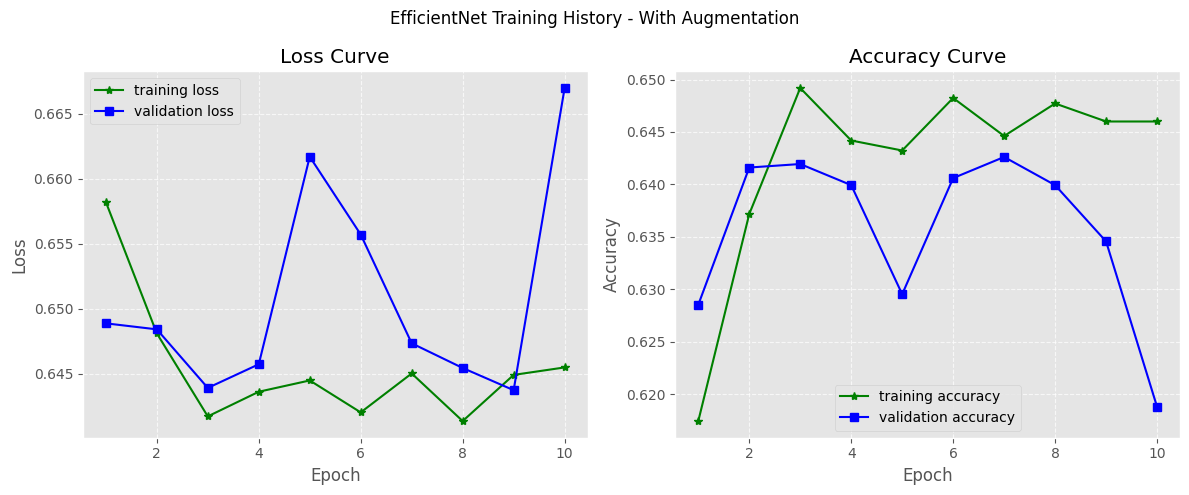

In [33]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

epochs = range(1, len(history_aug["train_losses"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("EfficientNet Training History - With Augmentation")

ax[0].plot(epochs, history_aug["train_losses"], label='training loss', marker='*', color='green')
ax[0].plot(epochs, history_aug["valid_losses"], label='validation loss', marker='s', color='blue')
ax[0].set_title("Loss Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.7)

ax[1].plot(epochs, history_aug["train_accuracy"], label='training accuracy', marker='*', color='green')
ax[1].plot(epochs, history_aug["valid_accuracy"], label='validation accuracy', marker='s', color='blue')
ax[1].set_title("Accuracy Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.7)

img_save = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}_pretrained.png"
plt.savefig(img_save)
plt.tight_layout()
plt.show()

### **Fine-Tuning**

In [34]:
# Unfreeze for Fine-Tuning
for param in model.parameters():
    param.requires_grad = True

In [35]:
optimizer = optim.Adam(model.parameters(), lr=LR_STAGE_2, weight_decay=WEIGHT_DECAY)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters (Stage 2): {trainable_params}")

Trainable Parameters (Stage 2): 4010110


In [36]:
TOTAL_EPOCHS = EPOCHS_STAGE_1 + EPOCHS_STAGE_2
for epoch in range(EPOCHS_STAGE_1, TOTAL_EPOCHS):
    # Train & Evaluate
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    print(f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    # Metrics record
    history_aug['train_losses'].append(train_loss)
    history_aug['valid_losses'].append(valid_loss)
    history_aug['train_accuracy'].append(train_acc)
    history_aug['valid_accuracy'].append(valid_acc)
    history_aug['valid_f1'].append(valid_f1)
    history_aug['valid_auc'].append(valid_auc)
    
    # Save best model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"{MODEL_WEIGHTS}/best_{MODEL_NAME}_{TASK_NAME}_finetuned.pth"
        save_checkpoint(model, optimizer, save_name)
        
        # Update best stats
        history_aug['best_accuracy'] = best_acc
        history_aug['best_epoch'] = epoch + 1
        history_aug['model_saved_path'] = save_name
        
    print(f"\t- [current best] epoch: {history_aug['best_epoch']} - acc: {history_aug['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 94/94 [00:11<00:00,  7.98it/s]


[11/30 (Fine-Tune)] train_acc: 0.6842 - train_loss: 0.6112 - valid_acc: 0.7121 - valid_loss: 0.5803
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_finetuned.pth
	- [current best] epoch: 11 - acc: 0.7121



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  7.85it/s]


[12/30 (Fine-Tune)] train_acc: 0.7519 - train_loss: 0.5496 - valid_acc: 0.7621 - valid_loss: 0.5384
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_finetuned.pth
	- [current best] epoch: 12 - acc: 0.7621



Evaluating: 100%|██████████| 94/94 [01:10<00:00,  1.34it/s]


[13/30 (Fine-Tune)] train_acc: 0.7910 - train_loss: 0.5037 - valid_acc: 0.7852 - valid_loss: 0.5084
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_finetuned.pth
	- [current best] epoch: 13 - acc: 0.7852



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.05it/s]


[14/30 (Fine-Tune)] train_acc: 0.8259 - train_loss: 0.4617 - valid_acc: 0.8154 - valid_loss: 0.4792
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_finetuned.pth
	- [current best] epoch: 14 - acc: 0.8154



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.01it/s]


[15/30 (Fine-Tune)] train_acc: 0.8490 - train_loss: 0.4342 - valid_acc: 0.8265 - valid_loss: 0.4681
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_finetuned.pth
	- [current best] epoch: 15 - acc: 0.8265



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.02it/s]


[16/30 (Fine-Tune)] train_acc: 0.8695 - train_loss: 0.4097 - valid_acc: 0.8473 - valid_loss: 0.4463
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_finetuned.pth
	- [current best] epoch: 16 - acc: 0.8473



Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.31it/s]


[17/30 (Fine-Tune)] train_acc: 0.8812 - train_loss: 0.3947 - valid_acc: 0.8594 - valid_loss: 0.4353
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_finetuned.pth
	- [current best] epoch: 17 - acc: 0.8594



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  6.90it/s]


[18/30 (Fine-Tune)] train_acc: 0.8916 - train_loss: 0.3786 - valid_acc: 0.8691 - valid_loss: 0.4232
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_finetuned.pth
	- [current best] epoch: 18 - acc: 0.8691



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.07it/s]


[19/30 (Fine-Tune)] train_acc: 0.8990 - train_loss: 0.3682 - valid_acc: 0.8738 - valid_loss: 0.4163
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_finetuned.pth
	- [current best] epoch: 19 - acc: 0.8738



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.09it/s]


[20/30 (Fine-Tune)] train_acc: 0.9087 - train_loss: 0.3559 - valid_acc: 0.8742 - valid_loss: 0.4183
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_finetuned.pth
	- [current best] epoch: 20 - acc: 0.8742



Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.31it/s]


[21/30 (Fine-Tune)] train_acc: 0.9121 - train_loss: 0.3491 - valid_acc: 0.8842 - valid_loss: 0.4043
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_finetuned.pth
	- [current best] epoch: 21 - acc: 0.8842



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.11it/s]


[22/30 (Fine-Tune)] train_acc: 0.9216 - train_loss: 0.3399 - valid_acc: 0.8826 - valid_loss: 0.4007
	- [current best] epoch: 21 - acc: 0.8842



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.20it/s]


[23/30 (Fine-Tune)] train_acc: 0.9274 - train_loss: 0.3293 - valid_acc: 0.8819 - valid_loss: 0.4036
	- [current best] epoch: 21 - acc: 0.8842



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.20it/s]


[24/30 (Fine-Tune)] train_acc: 0.9322 - train_loss: 0.3254 - valid_acc: 0.8812 - valid_loss: 0.4026
	- [current best] epoch: 21 - acc: 0.8842



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.20it/s]


[25/30 (Fine-Tune)] train_acc: 0.9341 - train_loss: 0.3215 - valid_acc: 0.8896 - valid_loss: 0.3948
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_finetuned.pth
	- [current best] epoch: 25 - acc: 0.8896



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.18it/s]


[26/30 (Fine-Tune)] train_acc: 0.9382 - train_loss: 0.3144 - valid_acc: 0.8926 - valid_loss: 0.3841
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_finetuned.pth
	- [current best] epoch: 26 - acc: 0.8926



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.07it/s]


[27/30 (Fine-Tune)] train_acc: 0.9402 - train_loss: 0.3108 - valid_acc: 0.8916 - valid_loss: 0.3939
	- [current best] epoch: 26 - acc: 0.8926



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  7.97it/s]


[28/30 (Fine-Tune)] train_acc: 0.9418 - train_loss: 0.3070 - valid_acc: 0.8990 - valid_loss: 0.3792
Checkpoint saved: ../model_checkpoints/efficient-net/best_efficientnet_with_aug_finetuned.pth
	- [current best] epoch: 28 - acc: 0.8990



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.00it/s]


[29/30 (Fine-Tune)] train_acc: 0.9437 - train_loss: 0.3049 - valid_acc: 0.8980 - valid_loss: 0.3826
	- [current best] epoch: 28 - acc: 0.8990



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  6.92it/s]

[30/30 (Fine-Tune)] train_acc: 0.9504 - train_loss: 0.2977 - valid_acc: 0.8936 - valid_loss: 0.3797
	- [current best] epoch: 28 - acc: 0.8990



In [37]:
save_name = f"{MODEL_WEIGHTS}/{MODEL_NAME}_{TASK_NAME}_finetuned.pth"
save_checkpoint(model, optimizer, save_name)

Checkpoint saved: ../model_checkpoints/efficient-net/efficientnet_with_aug_finetuned.pth


In [38]:
json_filename = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}.json"
save_experiment_json(history_aug, json_filename)

History saved to ../results/efficient-net/efficientnet_with_aug.json


<Figure size 1200x600 with 0 Axes>

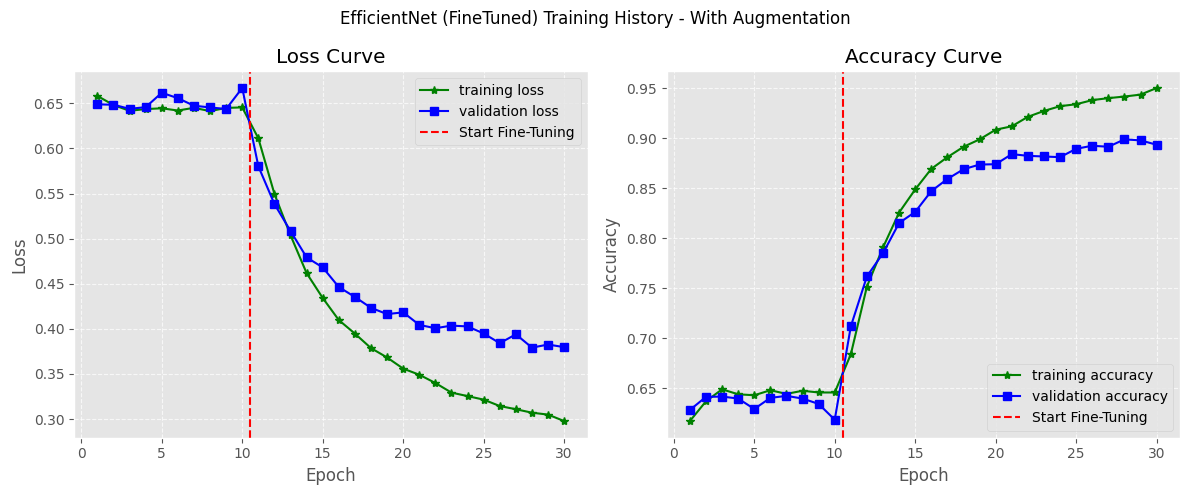

In [39]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))

epochs = range(1, len(history_aug["train_losses"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("EfficientNet (FineTuned) Training History - With Augmentation")

ax[0].plot(epochs, history_aug["train_losses"], label='training loss', marker='*', color='green')
ax[0].plot(epochs, history_aug["valid_losses"], label='validation loss', marker='s', color='blue')
ax[0].set_title("Loss Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].axvline(x=EPOCHS_STAGE_1 + 0.5, color='red', linestyle='--', label='Start Fine-Tuning')
ax[0].legend()

ax[1].plot(epochs, history_aug["train_accuracy"], label='training accuracy', marker='*', color='green')
ax[1].plot(epochs, history_aug["valid_accuracy"], label='validation accuracy', marker='s', color='blue')
ax[1].set_title("Accuracy Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].axvline(x=EPOCHS_STAGE_1 + 0.5, color='red', linestyle='--', label='Start Fine-Tuning')
ax[1].legend()

img_save = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}_finetuned.png"
plt.savefig(img_save)
plt.tight_layout()
plt.show()

Getting predictions: 100%|██████████| 95/95 [01:11<00:00,  1.33it/s]

Accuracy score: 0.8974
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1510
           1       0.87      0.94      0.90      1510

    accuracy                           0.90      3020
   macro avg       0.90      0.90      0.90      3020
weighted avg       0.90      0.90      0.90      3020



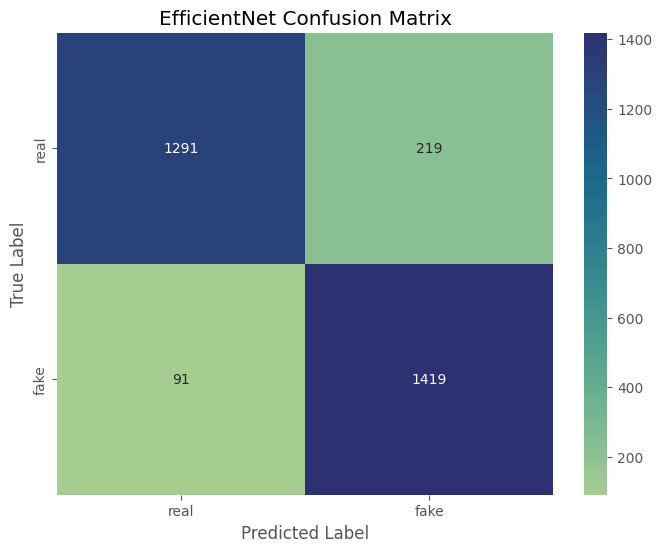

In [40]:
performance(model, test_loader, DEVICE, "EfficientNet", TASK_NAME, RESULTS_DIR)

In [20]:
save_name = f"{MODEL_WEIGHTS}/{MODEL_NAME}_{TASK_NAME}_finetuned.pth"
checkpoint = torch.load(save_name, map_location=DEVICE)
model.load_state_dict(checkpoint["state_dict"])
model = model.to(device=DEVICE)

Deepfakes : 0.9636
Face2Face : 0.9371
FaceSwap : 0.9305
FaceShifter : 0.9735
NeuralTextures : 0.8974


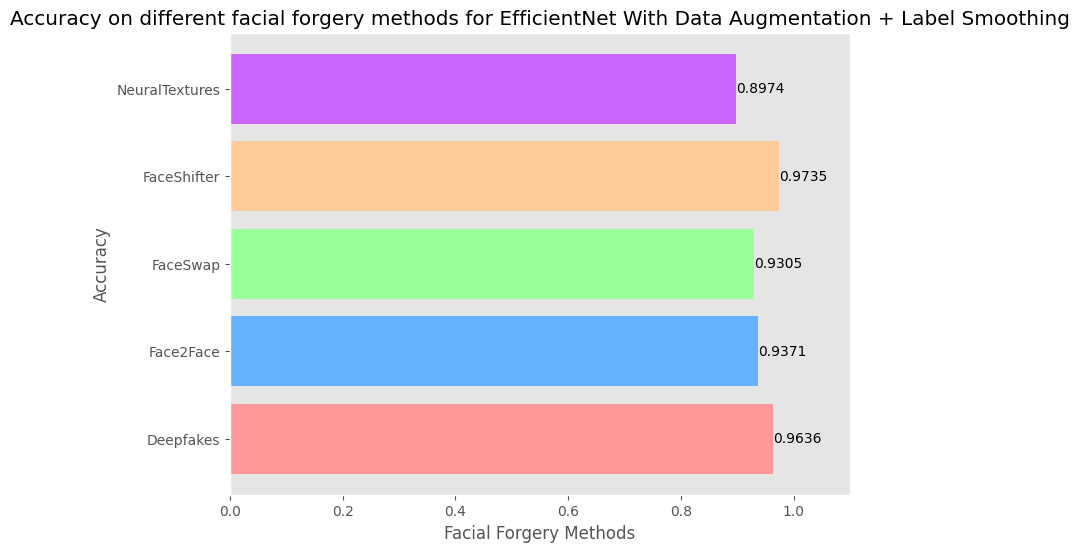

In [21]:
summary = error_analysis(model = model, fake_image_path = f"{project_root}/data/test/fake", model_name = MODEL_NAME, device = DEVICE)
plot_error_analysis(summary, model_name = "EfficientNet With Data Augmentation + Label Smoothing")